### **This Project for Face Emotion Classification**

# Import

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
import matplotlib.pyplot as plt
from keras.utils import plot_model
from zipfile import ZipFile
from google.colab import drive

# Read data

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile ('drive/MyDrive/Project/FaceEmotion.zip','r') as ZipObj:
  ZipObj.extractall('drive/MyDrive/Project/FaceEmotion')

In [ ]:
# This line sets the path to the training data directory
train_path='drive/MyDrive/Project/FaceEmotion/FaceEmotion/Micro_Expressions/train/'

# This line sets the path to the testing data directory
test_path='drive/MyDrive/Project/FaceEmotion/FaceEmotion/Micro_Expressions/test/'

In [ ]:
# Import the glob module and give it an alias of "gb"
import glob as gb

# Loop through each subdirectory in the train_path directory
for folder in os.listdir(train_path):

    # Use glob to find all the .jpg files in the current subdirectory
    images = gb.glob(pathname=str(train_path + folder + '/*.jpg'))

    # Print out the number of images found in the current subdirectory
    print(f'for training data, found {len(images)} in folder {folder}')

for training data, found 1411 in folder anger
for training data, found 662 in folder disgust
for training data, found 479 in folder fear
for training data, found 1950 in folder happiness
for training data, found 644 in folder neutral
for training data, found 1369 in folder sadness
for training data, found 1085 in folder surprise


In [ ]:
# Loop through each subdirectory in the test_path directory
for folder in os.listdir(test_path ):

    images=gb.glob(pathname=str(test_path  + folder +'/*.jpg'))

    print(f'for training data, found {len(images)} in folder {folder}')

for training data, found 350 in folder anger
for training data, found 160 in folder disgust
for training data, found 120 in folder fear
for training data, found 480 in folder happiness
for training data, found 160 in folder neutral
for training data, found 330 in folder sadness
for training data, found 260 in folder surprise


In [ ]:
# This code reads in all JPEG images in each folder of the train_path directory and finds the unique shapes of the images and their corresponding counts.
#It then prints out each unique shape and its count.
#and that help us know what the inputshape that we will give it to the model.
#if we have a different size of image or not becouse we need to make all same size.
#This for train dataset.
size=[]
for folder in os.listdir(train_path):
    images=gb.glob(pathname=str(train_path + folder +'/*.jpg'))
    for img in images:
        img=plt.imread(img)
        size.append(img.shape)
pd.Series(size).value_counts()

(80, 80, 3)    7600
dtype: int64

In [ ]:
#This for test dataset.
size=[]
for folder in os.listdir(test_path):
    images=gb.glob(pathname=str(test_path + folder +'/*.jpg'))
    for img in images:
        img=plt.imread(img)
        size.append(img.shape)
pd.Series(size).value_counts()

(80, 80, 3)    1860
dtype: int64

In [ ]:
code={'anger':0 ,'disgust':1,'fear':2,'happiness':3,'neutral':4,'sadness':5,'surprise':6}
def getname(n):

    for k,v in code.items():
     if v==n:
        return k

In [ ]:
#read train data, and split train into (x,y)
x_train=[]
y_train=[]
for folder in os.listdir(train_path ):
    images=gb.glob(pathname=str(train_path  + folder +'/*.jpg'))
    for img in images:
        img=cv.imread(img)
        x_train.append(img)
        y_train.append(code[folder])

In [ ]:
#read test data, and split test data into (x.y)
x_test=[]
y_test=[]
for folder in os.listdir(test_path ):
    images=gb.glob(pathname=str(test_path  + folder +'/*.jpg'))
    for img in images:
        img=cv.imread(img)
        x_test.append(img)
        y_test.append(code[folder])

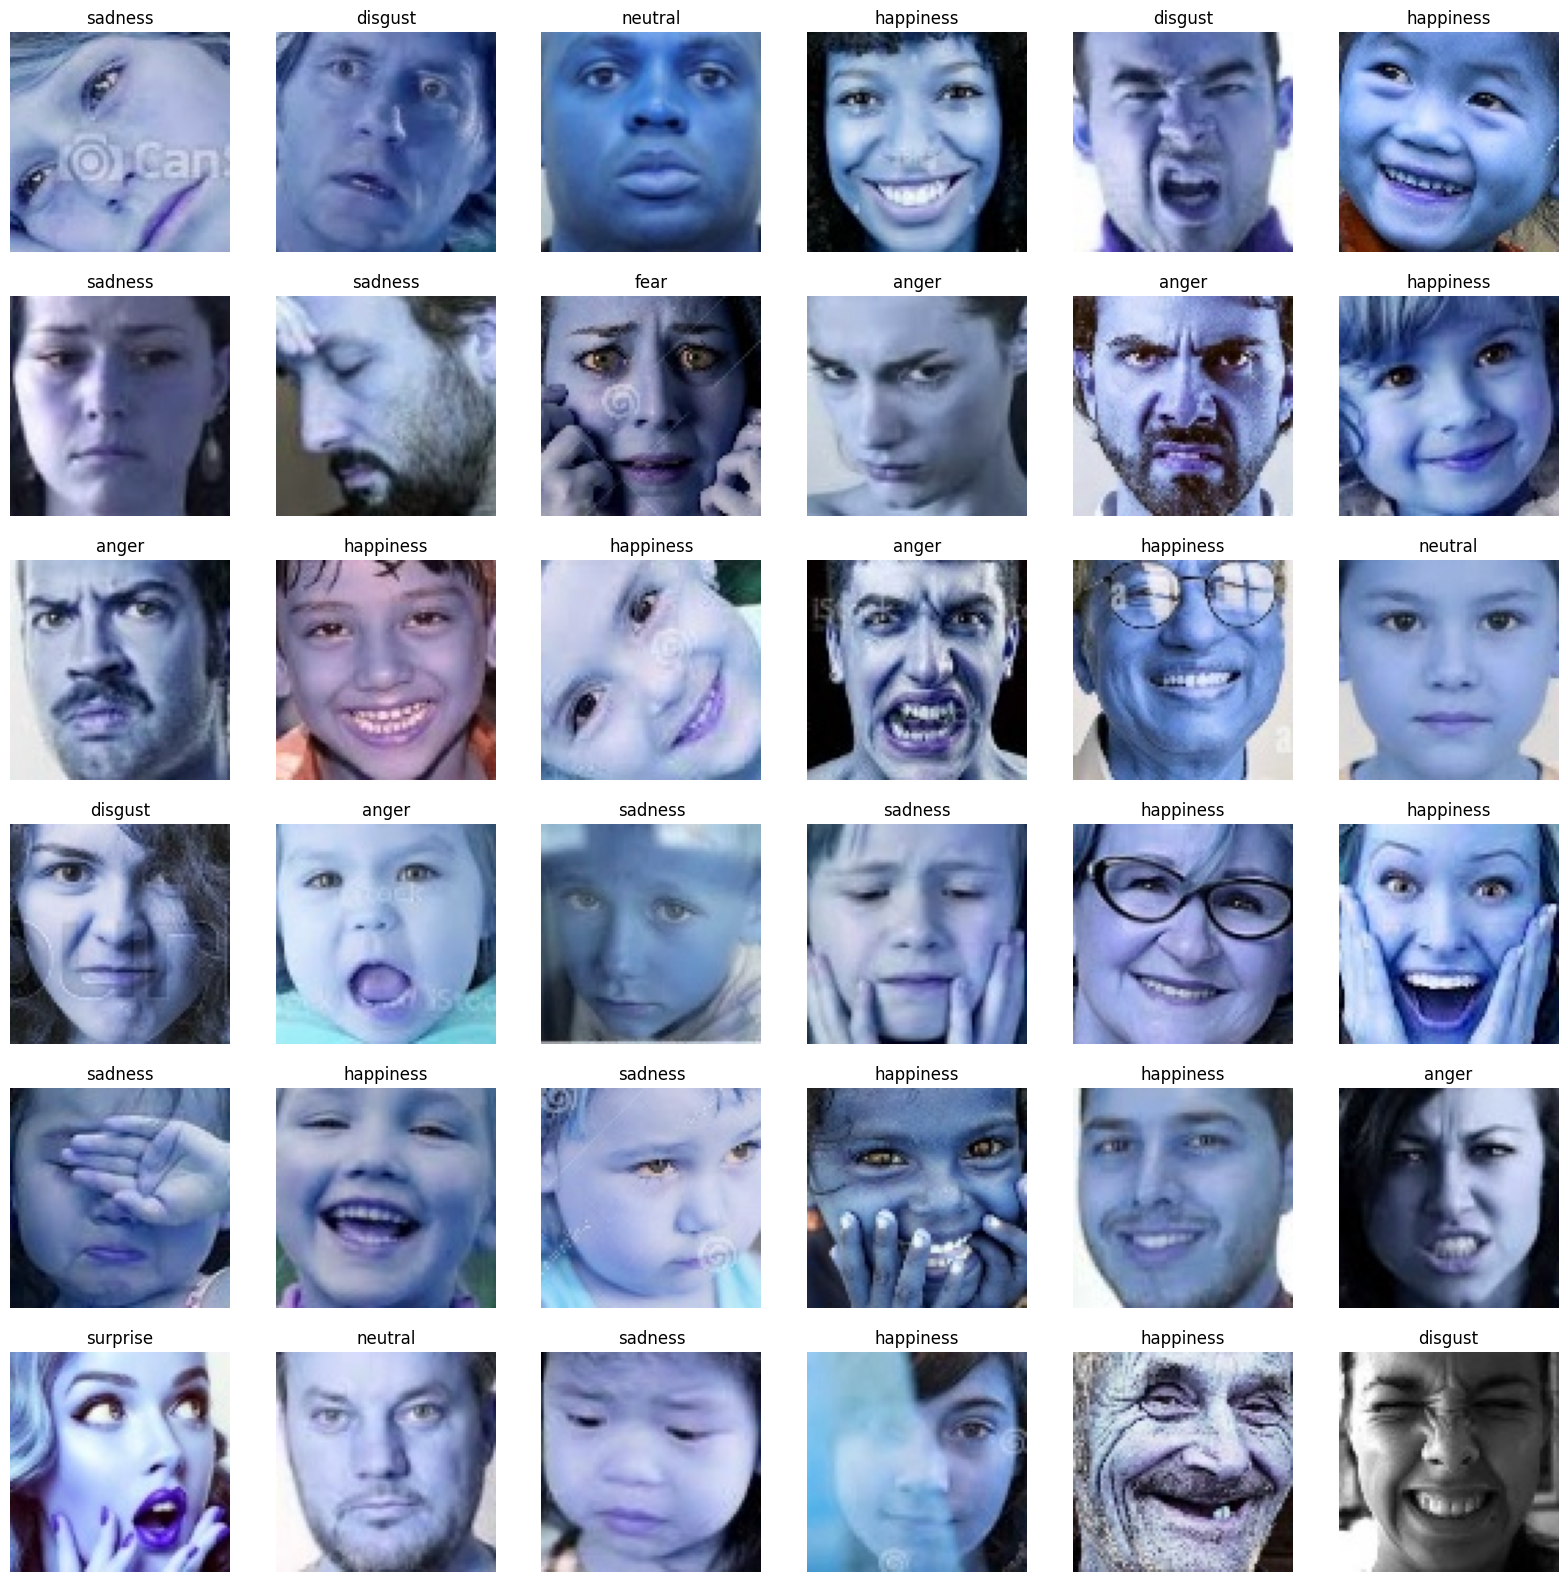

In [ ]:
#visualization of a random selection of images from the x_train dataset, with their corresponding labels.
plt.figure(figsize=(20,20))
for i,v in enumerate(np.random.randint(0,len(x_train),36)):
    plt.subplot(6,6,i+1)
    plt.imshow(x_train[v])
    plt.title(getname(y_train[v]))
    plt.axis('off')

# Preprocessing and Split Dataset

In [ ]:
height,width=80,80
input_shape=(80, 80, 3)
num_classes = 7
batch_size=16

In [ ]:
# Load the training set from the specified directory, with a 90/10 train/validation split
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,   # 10% of the data will be used for validation
    subset="training",      # Use the training subset of the data
    seed=123,               # Set a random seed for reproducibility
    image_size=(height,width),  # Resize the images to the specified height and width
    batch_size=batch_size   # Set the batch size for training
)

# Load the validation set from the same directory, with the same 90/10 split
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,   # 10% of the data will be used for validation
    subset="validation",    # Use the validation subset of the data
    seed=123,               # Set a random seed for reproducibility
    image_size=(height, width), # Resize the images to the specified height and width
    batch_size=batch_size   # Set the batch size for validation
)

# Load the test set from the specified directory
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(height, width), # Resize the images to the specified height and width
    batch_size=batch_size   # Set the batch size for testing
)

Found 7600 files belonging to 7 classes.
Using 6840 files for training.
Found 7600 files belonging to 7 classes.
Using 760 files for validation.
Found 1860 files belonging to 7 classes.


# EarlyStop And Checkpoint

In [ ]:
# This for sets up early stopping during training.
#'val_loss' is monitored, and training stops if it doesn't improve for 8 epochs.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

#This for sets up model checkpointing during training.
#'val_accuracy' is monitored, and the best model is saved to 'best_model.h5'.
#Only the best model is saved, based on validation accuracy.
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# VGG

In [ ]:
# Create a new sequential model
vgg = Sequential()

# Import the VGG19 model from Keras applications, excluding the top layer
imported_model = tf.keras.applications.VGG19(
    include_top=False, # Exclude the top layer
    input_shape=input_shape, # Set the input shape of the model
    pooling='max', # Use max pooling to reduce the spatial dimensions of the output
    classes=7, # Set the number of output classes to 7
    weights='imagenet' # Use pre-trained weights from the ImageNet dataset
)

# Add the imported VGG19 model to the new sequential model
vgg.add(imported_model)

# Flatten the output of the VGG19 model to a 1D vector
vgg.add(Flatten())

# Add a dense layer with 7 output units and a softmax activation function
# Use L2 regularization with a strength of 0.001 to prevent overfitting
vgg.add(Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
# Compile the model with the following configurations:
vgg.compile(
    # Use the Adam optimizer with a learning rate of 0.000000001
    optimizer=Adam(lr=0.000000001),
    # Use sparse categorical crossentropy as the loss function
    loss='sparse_categorical_crossentropy',
    # Track accuracy as a metric during training and evaluation
    metrics=['accuracy']
)

In [ ]:
#summary of the model
vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 20027975 (76.40 MB)
Trainable params: 20027975 (76.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the VGG model for 15 epochs using the training set and validation set,
# and use the EarlyStopping and ModelCheckpoint callbacks to stop training early
# and save the best model based on validation accuracy
history2 = vgg.fit(x = train_set,epochs = 15,validation_data = validation_set,callbacks=[es, mc])

Epoch 1/15
428/428 [==============================] - ETA: 0s - loss: 2.5116 - accuracy: 0.2510
Epoch 1: val_accuracy improved from -inf to 0.27500, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


428/428 [==============================] - 38s 68ms/step - loss: 2.5116 - accuracy: 0.2510 - val_loss: 1.7877 - val_accuracy: 0.2750
Epoch 2/15
427/428 [============================>.] - ETA: 0s - loss: 1.6235 - accuracy: 0.3769
Epoch 2: val_accuracy improved from 0.27500 to 0.45658, saving model to best_model.h5
428/428 [==============================] - 28s 65ms/step - loss: 1.6229 - accuracy: 0.3772 - val_loss: 1.4402 - val_accuracy: 0.4566
Epoch 3/15
427/428 [============================>.] - ETA: 0s - loss: 1.3794 - accuracy: 0.4770
Epoch 3: val_accuracy improved from 0.45658 to 0.47500, saving model to best_model.h5
428/428 [==============================] - 28s 66ms/step - loss: 1.3799 - accuracy: 0.4768 - val_loss: 1.2969 - val_accuracy: 0.4750
Epoch 4/15
427/428 [============================>.] - ETA: 0s - loss: 1.2600 - accuracy: 0.5176
Epoch 4: val_accuracy improved from 0.47500 to 0.54737, saving model to best_model.h5
428/428 [==============================] - 28s 65ms/ste

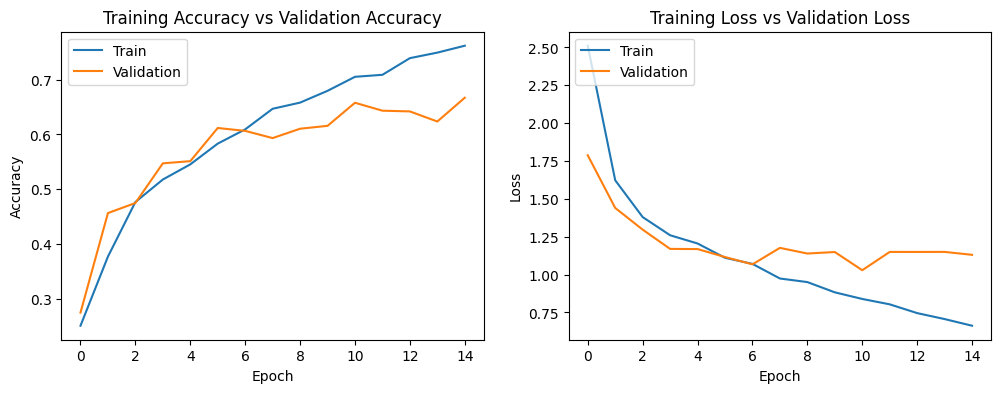

In [ ]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)

# Get the training accuracy and loss from the history object
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']

# Set the size of the figure
fig.set_size_inches(12, 4)

# Plot the training accuracy and validation accuracy on the first subplot
ax[0].plot(history2.history['accuracy'])
ax[0].plot(history2.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the training loss and validation loss on the second subplot
ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# Show the plot
plt.show()

# ResNet

In [ ]:
# Create a sequential model
res = Sequential()

# Import a pre-trained ResNet50 model with the following configurations:
# - include_top=False: exclude the top (fully connected) layers of the model
# - input_shape: specify the shape of the input images
# - pooling='max': use max pooling to reduce the spatial dimensions of the output
# - classes=7: specify the number of output classes
# - weights='imagenet': initialize the model with pre-trained weights on the ImageNet dataset
imported_model = tf.keras.applications.ResNet50(include_top=False,
                                                input_shape=input_shape,
                                                pooling='max',
                                                classes=7,
                                                weights='imagenet')

# Add the imported ResNet50 model to the sequential model
res.add(imported_model)

# Add a flatten layer to convert the output of the ResNet50 model to a 1D array
res.add(Flatten())

# Add a dense layer with softmax activation to output the predicted class probabilities
# Use L2 regularization with a regularization strength of 0.001 to prevent overfitting
res.add(Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compile the model with the following configurations:
res.compile(
    # Use the Adam optimizer with a learning rate of 0.000000001
    optimizer=Adam(lr=0.000000001),
    # Use sparse categorical crossentropy as the loss function
    loss='sparse_categorical_crossentropy',
    # Track accuracy as a metric during training and evaluation
    metrics=['accuracy']
)

In [ ]:
#summary of the model
res.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# Train the VGG model for 15 epochs using the training set and validation set,
# and use the EarlyStopping and ModelCheckpoint callbacks to stop training early
# and save the best model based on validation accuracy
history3 = res.fit(x = train_set,epochs = 15,validation_data = validation_set,callbacks=[es, mc])

Epoch 1/15
428/428 [==============================] - ETA: 0s - loss: 1.4758 - accuracy: 0.5383
Epoch 1: val_accuracy improved from -inf to 0.47237, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


428/428 [==============================] - 951s 2s/step - loss: 1.4758 - accuracy: 0.5383 - val_loss: 2.7052 - val_accuracy: 0.4724
Epoch 2/15
428/428 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.6700
Epoch 2: val_accuracy improved from 0.47237 to 0.59211, saving model to best_model.h5
428/428 [==============================] - 26s 60ms/step - loss: 0.9880 - accuracy: 0.6700 - val_loss: 1.2724 - val_accuracy: 0.5921
Epoch 3/15
428/428 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.6962
Epoch 3: val_accuracy improved from 0.59211 to 0.66579, saving model to best_model.h5
428/428 [==============================] - 26s 59ms/step - loss: 0.9018 - accuracy: 0.6962 - val_loss: 1.0193 - val_accuracy: 0.6658
Epoch 4/15
428/428 [==============================] - ETA: 0s - loss: 0.8109 - accuracy: 0.7344
Epoch 4: val_accuracy did not improve from 0.66579
428/428 [==============================] - 24s 55ms/step - loss: 0.8109 - accuracy: 0.7344 

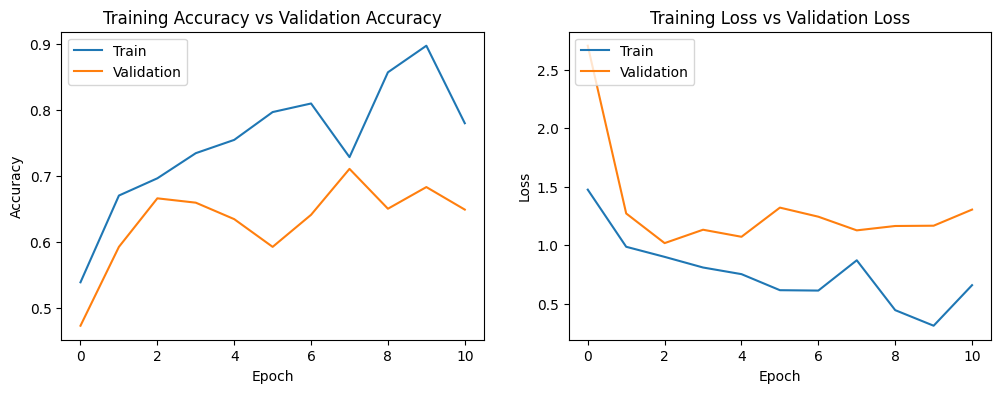

In [ ]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)

# Get the training accuracy and loss from the history object
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']

# Set the size of the figure
fig.set_size_inches(12, 4)

# Plot the training accuracy and validation accuracy on the first subplot
ax[0].plot(history3.history['accuracy'])
ax[0].plot(history3.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the training loss and validation loss on the second subplot
ax[1].plot(history3.history['loss'])
ax[1].plot(history3.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# Show the plot
plt.show()

# EfficientNet

In [ ]:
# Import the EfficientNetV2B3 model from Keras applications
imported_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                                                        input_shape=input_shape,
                                                        pooling='max',
                                                        classes=7,
                                                        weights='imagenet')

# Create a new sequential model
model = Sequential()

# Add the imported model as a layer to the new model
model.add(imported_model)

# Add a flatten layer to the new model
model.add(Flatten())

# Add a dense layer with softmax activation and L2 regularization to the new model
model.add(Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

52606240/52606240 [==============================] - 2s 0us/step


In [ ]:
# Compile the model with the following configurations:
model.compile(
    # Use the Adam optimizer with a learning rate of 0.000000001
    optimizer=Adam(lr=0.000000001),
    # Use sparse categorical crossentropy as the loss function
    loss='sparse_categorical_crossentropy',
    # Track accuracy as a metric during training and evaluation
    metrics=['accuracy']
)

In [ ]:
#summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 10759     
                                                                 
Total params: 12941381 (49.37 MB)
Trainable params: 12832165 (48.95 MB)
Non-trainable params: 109216 (426.62 KB)
_________________________________________________________________


In [ ]:
# Train the EfficientNet model for 15 epochs using the training set and validation set,
# and use the EarlyStopping and ModelCheckpoint callbacks to stop training early
# and save the best model based on validation accuracy
history = model.fit(x = train_set,epochs = 15,validation_data = validation_set,callbacks=[es, mc])

Epoch 1/15
428/428 [==============================] - ETA: 0s - loss: 1.1621 - accuracy: 0.6080
Epoch 1: val_accuracy improved from -inf to 0.75132, saving model to best_model.h5
428/428 [==============================] - 126s 122ms/step - loss: 1.1621 - accuracy: 0.6080 - val_loss: 0.7581 - val_accuracy: 0.7513
Epoch 2/15
428/428 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.7743
Epoch 2: val_accuracy improved from 0.75132 to 0.76842, saving model to best_model.h5
428/428 [==============================] - 47s 111ms/step - loss: 0.6963 - accuracy: 0.7743 - val_loss: 0.7381 - val_accuracy: 0.7684
Epoch 3/15
428/428 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.8213
Epoch 3: val_accuracy improved from 0.76842 to 0.76974, saving model to best_model.h5
428/428 [==============================] - 49s 114ms/step - loss: 0.5318 - accuracy: 0.8213 - val_loss: 0.7307 - val_accuracy: 0.7697
Epoch 4/15
428/428 [==============================] - 

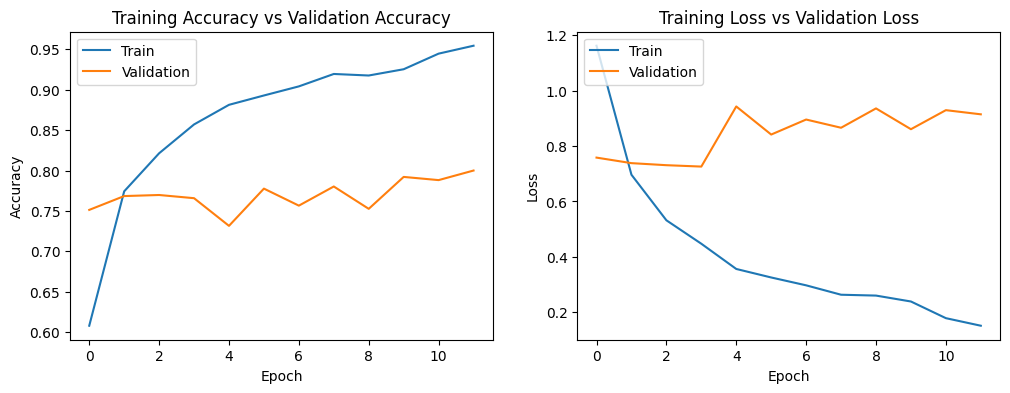

In [ ]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)

# Get the training accuracy and loss from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# Set the size of the figure
fig.set_size_inches(12, 4)

# Plot the training accuracy and validation accuracy on the first subplot
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the training loss and validation loss on the second subplot
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# Show the plot
plt.show()


In [ ]:
# Evaluate the model on the training set and get the loss and accuracy
train_loss, train_acc = model.evaluate(train_set)

# Evaluate the model on the validation set and get the loss and accuracy
test_loss, test_acc = model.evaluate(validation_set)

# Print the final training accuracy and validation accuracy
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

48/48 [==============================] - 2s 29ms/step - loss: 0.9144 - accuracy: 0.8000
final train accuracy = 97.22 , validation accuracy = 80.00


In [ ]:
# Load the saved model from the file 'best_model.h5'
model = load_model('best_model.h5')

In [ ]:
# Use the loaded model to make predictions on the test set
y_pred = model.predict(test_set)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Save the weights of the model to a file
model.save_weights('model_weights.h5')

# Summary

In this project i wanted to build a model classifying the face emotion depend on the images, and the labels was (anger, disgust, fear, happiness, neutral, sadness and surprise)
so i have used 3 different models(VGG19, Resnet and EfficientNet)
for:

-----------------------------------------------------------------------------------------
 VGG19 has 20 million parameters, and the best accuracy it had in train : 0.7620 , validation :  0.6671

 ResNet has 23 million parameters, and the best accuracy it had in train : 0.7798 , validation : 0.6487

 EfficientNet  has 12 million parameters, and the best accuracy it had in train : 0.9144 , validation : 0.8000

----------------------------------------------------------------------------------------------------

so we conclude that  even EfficientNet has less parameters than other models it had the more accurately in validation
